In [3]:
import ismrmrd
import rtoml
import os
import fnmatch
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt


# Read config
with open('config.toml', 'r') as cf:
    cfg = rtoml.load(cf)

DATA_ROOT = cfg['DATA_ROOT']
DATA_DIR = cfg['data_folder']
raw_file = cfg['raw_file']
gpu_device = cfg['gpu_num']

data_dir_path = os.path.join(DATA_ROOT, DATA_DIR, 'raw/h5')
if raw_file.isnumeric():
    raw_file_ = fnmatch.filter(os.listdir(data_dir_path), f'meas_MID*{raw_file}*.h5')[0]
    ismrmrd_data_fullpath = os.path.join(data_dir_path, raw_file_)
elif raw_file.startswith('meas_MID'):
    raw_file_ = raw_file
    ismrmrd_data_fullpath = os.path.join(data_dir_path, raw_file)
else:
    print('Could not find the file. Exiting...')
    exit(-1)


In [4]:
# Read the data in
print(f'Reading {ismrmrd_data_fullpath}...')
with ismrmrd.Dataset(ismrmrd_data_fullpath) as dset:

    n_acq = dset.number_of_acquisitions()
    print(f'There are {n_acq} acquisitions in the file. Reading...')

    acq_list = []
    for ii in range(n_acq):
        acq_list.append(dset.read_acquisition(ii))

    n_wf = dset.number_of_waveforms()
    print(f'There are {n_wf} waveforms in the dataset. Reading...')

    wf_list = []
    for ii in range(n_wf):
        wf_list.append(dset.read_waveform(ii))
    
    hdr = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())

# get the k-space trajectory based on the metadata hash.
traj_name = hdr.userParameters.userParameterString[1].value

# load the .mat file containing the trajectory
traj = loadmat(os.path.join(DATA_ROOT, DATA_DIR, traj_name), squeeze_me=True)

n_unique_angles = int(traj['param']['repetitions'])

kx = traj['kx'][:,:]
ky = traj['ky'][:,:]
dt = float(traj['param']['dt'])
msize = int(10 * traj['param']['fov'] / traj['param']['spatial_resolution'])
pre_discard = int(traj['param']['pre_discard'])
w = traj['w']

# Convert raw data and trajectory into convenient arrays
ktraj = np.stack((kx, -ky), axis=2)
# find max ktraj value
kmax = np.max(np.abs(kx + 1j * ky))
# swap 0 and 1 axes to make repetitions the first axis (repetitions, interleaves, 2)
ktraj = np.swapaxes(ktraj, 0, 1)
ktraj = 0.5 * (ktraj / kmax) * msize

data = [arm.data[:,:] for arm in acq_list]
dcf = np.tile(w[None, :], (n_acq, 1))
coord = [ktraj[ii%n_unique_angles,:,:] for ii in range(n_acq)]

data = np.array(data)
data = np.transpose(data, axes=(2, 0, 1))
coord = np.array(coord, dtype=np.float32)
coord = np.transpose(coord, axes=(2, 1, 0))


Reading /server/home/btasdelen/MRI_DATA/pilottone/vol0902_20240611/raw/h5/meas_MID00175_FID15580_pulseq2D_fire_spiralga_400mV_24MHz.h5...
There are 14400 acquisitions in the file. Reading...
There are 4427 waveforms in the dataset. Reading...


Coils to be used as sniffers: ['Spine_18:1:S4T' 'Spine_18:1:S4S' 'Spine_18:1:S4P']


/server/home/btasdelen/miniforge3/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


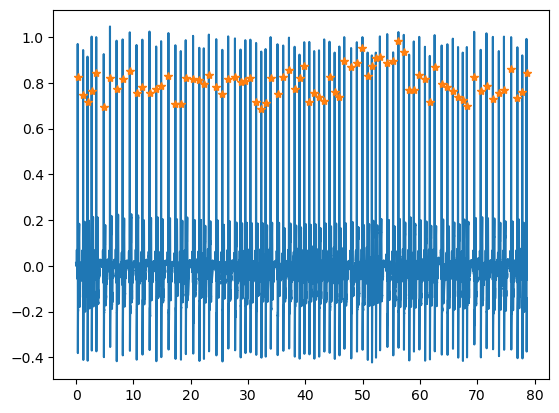

In [5]:
mri_coils = np.arange(15, dtype=int)
sensing_coils = np.array([15, 16, 17], dtype=int)
coil_name = []

for clbl in hdr.acquisitionSystemInformation.coilLabel:
    coil_name.append(clbl.coilName)

coil_name = np.asarray(coil_name)

print(f"Coils to be used as sniffers: {coil_name[sensing_coils.astype(int)]}")

f0 = hdr.experimentalConditions.H1resonanceFrequency_Hz
df = 1/(dt*data.shape[0])

t_acq_start = acq_list[0].acquisition_time_stamp*2.5e-3 # [2.5ms] -> [s]
t_acq_end = acq_list[-1].acquisition_time_stamp*2.5e-3
time_acq = np.linspace(t_acq_start, t_acq_end, n_acq) # Interpolate for TR, as TR will not be a multiple of time resolution.
time_pt = time_acq - t_acq_start
samp_time_pt = time_acq[1] - time_acq[0]

ksp_measured = data[:,:,mri_coils]
ksp_sniffer  = data[:,:,sensing_coils]

## Process ECG waveform
ecg_waveform = []
ecg_trigs = []
wf_init_timestamp = 0
for wf in wf_list:
    if wf.getHead().waveform_id == 0:
        ecg_waveform.append(wf.data[0,:])
        ecg_trigs.append(wf.data[4,:])
        if wf_init_timestamp == 0:
            wf_init_timestamp = wf.time_stamp
            ecg_sampling_time = wf_list[0].getHead().sample_time_us*1e-6 # [us] -> [s]

ecg_waveform = (np.asarray(np.concatenate(ecg_waveform, axis=0), dtype=float)-2048)
ecg_waveform = ecg_waveform/np.percentile(ecg_waveform, 99.9)
ecg_trigs = (np.concatenate(ecg_trigs, axis=0)/2**14).astype(int)
time_ecg = np.arange(ecg_waveform.shape[0])*ecg_sampling_time - (acq_list[0].acquisition_time_stamp - wf_init_timestamp)*1e-3
plt.figure()
plt.plot(time_ecg, ecg_waveform)
plt.plot(time_ecg[ecg_trigs==1], ecg_waveform[ecg_trigs==1], '*')

## PT correction

/server/home/btasdelen/miniforge3/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/server/home/btasdelen/miniforge3/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/server/home/btasdelen/miniforge3/envs/pilottone/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


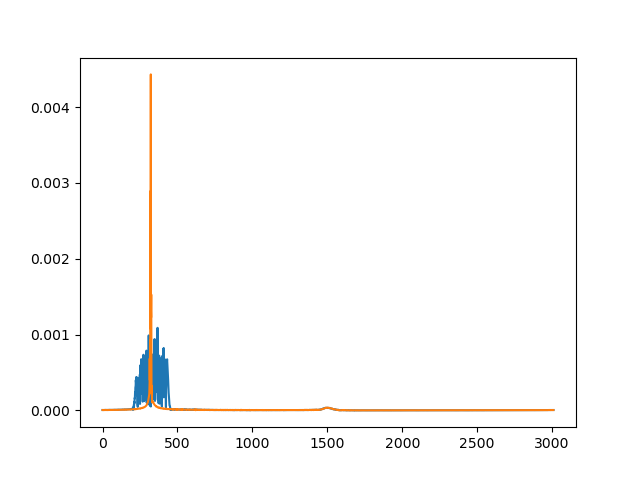

In [6]:
%matplotlib widget
from pilottone import pt
import importlib

f_pt = 24e6 # [Hz]
f_diff = f0 - f_pt

# ================================
# Demodulate any shifts
# ================================
phase_mod_rads = pt.calc_fovshift_phase(
    np.vstack((np.zeros((pre_discard, n_unique_angles)), kx)), 
    np.vstack((np.zeros((pre_discard, n_unique_angles)), ky)), 
    acq_list[0])
phase_mod_rads = [phase_mod_rads[:,ii%n_unique_angles] for ii in range(n_acq)]
phase_mod_rads = np.array(phase_mod_rads)[:, :].transpose()[:,:,None]

# Apply the negative of the phase
ksp_sniffer_  = ksp_sniffer*phase_mod_rads
ksp_measured_ = ksp_measured*phase_mod_rads

plt.figure()
plt.plot(np.abs(pt.to_hybrid_kspace(ksp_measured[:,10,0])))
plt.plot(np.abs(pt.to_hybrid_kspace(ksp_measured_[:,10,0])))
plt.show()



10.893492698669434


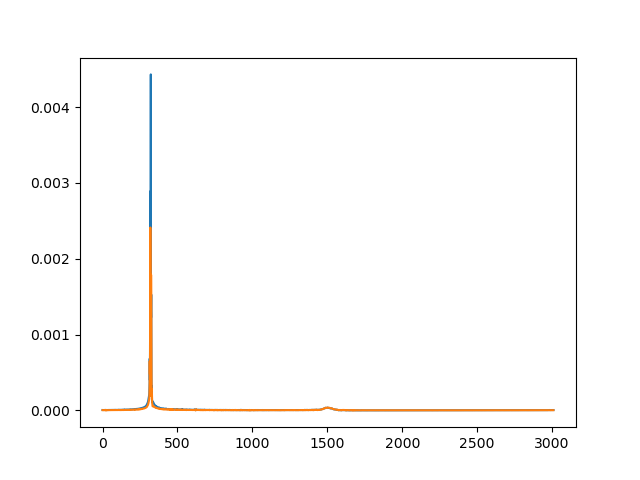

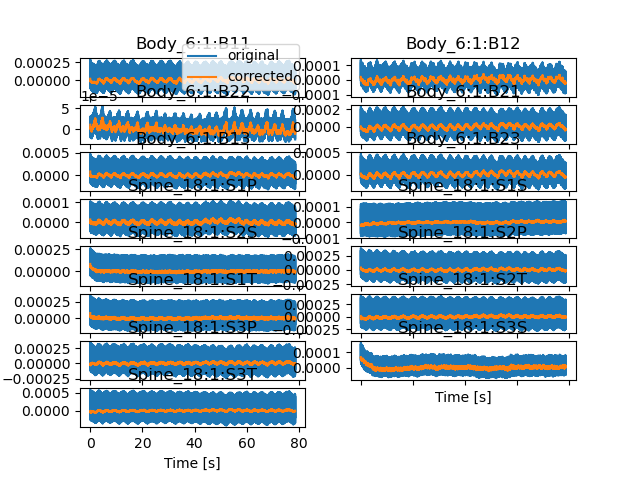

In [7]:
importlib.reload(pt)
from scipy.signal.windows import tukey

fcorrmin = pt.find_freq_qifft(ksp_measured_[:,:,:], df, f_diff, 3e3, 4, (2))

ksp_window = np.ones(ksp_measured_.shape[0])
# ksp_window = ksp_window[nc:]
ksp_measured_ = ksp_measured_*ksp_window[:,None,None]
ksp_sniffer_ = ksp_sniffer_*ksp_window[:,None,None]

time_acq = np.arange(0, ksp_measured_.shape[0])*dt

ksp_ptsubbed, pt_sig_fit = pt.est_dtft(time_acq, ksp_measured_, np.array([f_diff])-fcorrmin, ksp_window)
_, pt_sig_fit_sniffer = pt.est_dtft(time_acq, ksp_sniffer_, np.array([f_diff])-fcorrmin, ksp_window)

pt_sig_fit = np.abs(pt_sig_fit)
pt_sig_fit_sniffer = np.abs(pt_sig_fit_sniffer)
pt_sig = np.squeeze(pt_sig_fit - np.mean(pt_sig_fit, axis=1, keepdims=True))
pt_sig_sniffer = np.squeeze(pt_sig_fit_sniffer - np.mean(pt_sig_fit_sniffer, axis=1, keepdims=True))

plt.figure()
plt.plot(np.abs(pt.to_hybrid_kspace(ksp_measured_[:,10,0])))
plt.plot(np.abs(pt.to_hybrid_kspace(ksp_ptsubbed[:,10,0])))
plt.show()


# Pilot tone cleanup?
pt_sig_clean = pt.sniffer_sub(pt_sig, pt_sig_sniffer)

pt.plot_multich_comparison(time_pt, (pt_sig, pt_sig_clean), coil_name[mri_coils], ('original', 'corrected'))



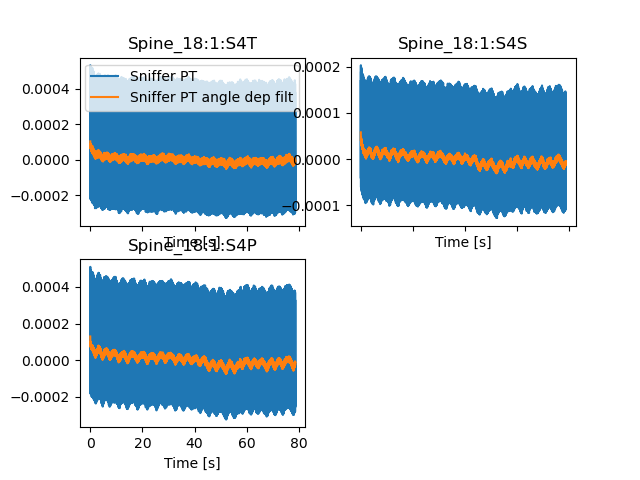

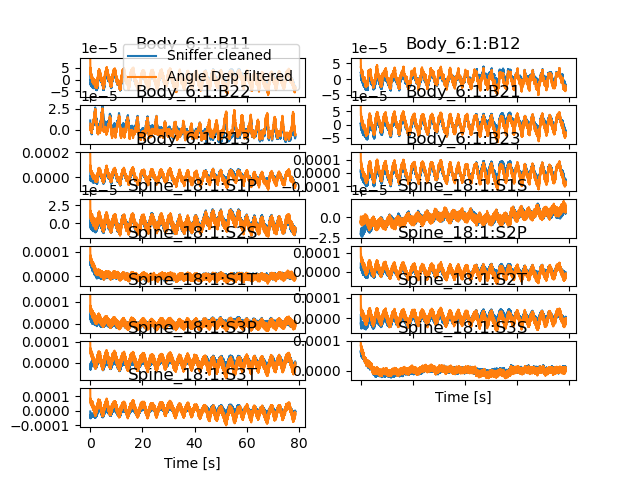

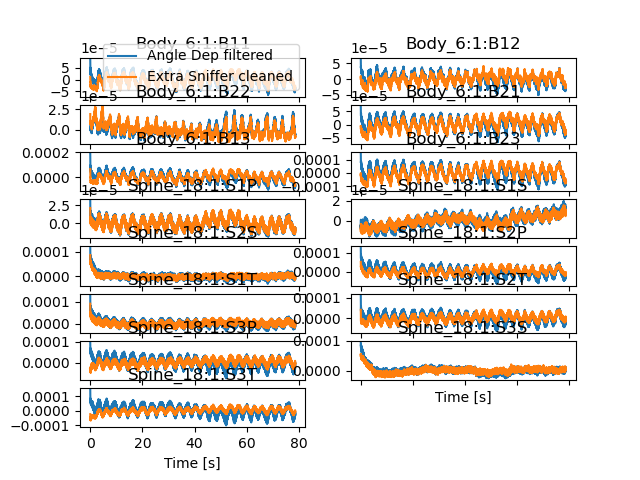

In [8]:
import numpy.typing as npt

def angle_dependant_filtering(sig: npt.NDArray[np.float64], n_unique_angles: int, angle_step:float=222.4922, pdegree:int=9) -> npt.NDArray[np.float64]:
    n_acq, nc = sig.shape[0:2]
    nrep = n_acq//n_unique_angles 
    angs = np.arange(n_unique_angles)*angle_step % 360
    angs_sorted = np.sort(angs)
    angles = np.tile(angs, (nrep,))
    I = np.argsort(angles)
    Irev = np.argsort(I)
    # plt.figure()
    # plt.plot(angles[I], sig[I, 4], '.')
    # plt.show()
    pt_sig_mean = np.mean(sig[I,:].reshape((n_unique_angles, nrep, nc)), axis=1)

    # plt.figure()
    # plt.plot(pt_sig_mean, '.')
    # plt.show()

    from numpy.polynomial import Polynomial
    sig_filtered = np.zeros(sig.shape)
    for chi in range(nc):
        p = Polynomial.fit(angs_sorted, pt_sig_mean[:,chi], deg=pdegree)
        # xx, yy = p.linspace()
        # plt.figure()
        # plt.plot(np.sort(angs), pt_sig_mean[:,0], '.')
        # plt.plot(np.sort(angs), p(np.sort(angs)), '-')
        # plt.show()

        sig_filtered[:,chi] = (sig[I, chi] - p(angles[I]))[Irev]


    # plt.figure()
    # plt.plot(p(angles[I])[Irev], '*')
    return sig_filtered

pt_sig_clean2 = angle_dependant_filtering(pt_sig, n_unique_angles)
pt_sig_sniffer_clean2 = angle_dependant_filtering(pt_sig_sniffer, n_unique_angles)

pt.plot_multich_comparison(time_pt, (pt_sig_sniffer, pt_sig_sniffer_clean2), coil_name[sensing_coils], ('Sniffer PT','Sniffer PT angle dep filt'))
pt.plot_multich_comparison(time_pt, (pt_sig_clean, pt_sig_clean2), coil_name[mri_coils], ('Sniffer cleaned', 'Angle Dep filtered'))

pt_sig_clean3 = pt.sniffer_sub(pt_sig_clean2, pt_sig_sniffer_clean2)
pt.plot_multich_comparison(time_pt, (pt_sig_clean2, pt_sig_clean3), coil_name[mri_coils], ('Angle Dep filtered', 'Extra Sniffer cleaned'))


/server/home/btasdelen/miniforge3/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


0: 0.06508776421526775
1: 0.02540348793409365
2: 0.01958357232014195
3: 0.019063284402506382
4: 0.01895421552803111
5: 0.018931628540039488
6: 0.018918970332757513
7: 0.018913822994203015
8: 0.018909838313239762
9: 0.01890893819760741
10: 0.018905887493680124
11: 0.018901959945555123
12: 0.01890141719152849
13: 0.018899218874405387
14: 0.01889901734092971
15: 0.018898545009168634
16: 0.01889732046910037
17: 0.0188968757201256
18: 0.018896926865015474
19: 0.018897041847394894
20: 0.01889715061403529
21: 0.018897145071844007
22: 0.018897407625044545
23: 0.018897425800632053
24: 0.01889746617964129
25: 0.018897413363105475
26: 0.018897527297975964
27: 0.018897628008909994
28: 0.018897540501577104
29: 0.018897689048731414
30: 0.01889772889509861
31: 0.018897693748776645
32: 0.018897743902074424
33: 0.01889773958974015
34: 0.018897760107273426
35: 0.018897760940745092
36: 0.018897798519864298
37: 0.018897793285520343
38: 0.018897807186285545
39: 0.018897812911674552
40: 0.018897804193450447

Text(0.5, 0.98, 'Extracted PT navigators')

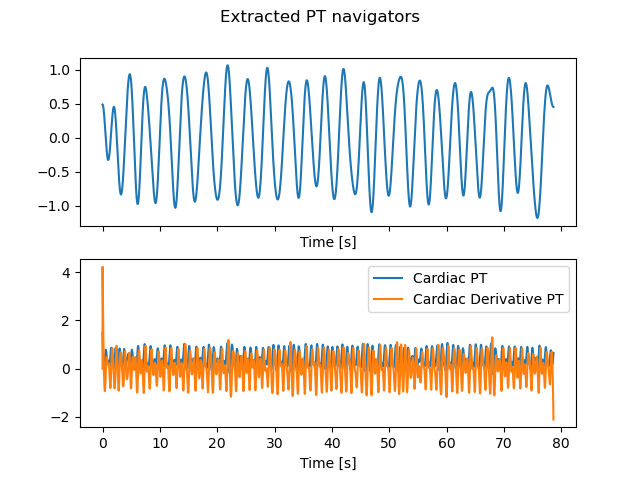

In [9]:
%matplotlib widget
importlib.reload(pt)

f_samp = 1/samp_time_pt # [Hz]
pt_extract_params = {'golay_filter_len': 81,
                   'respiratory': {
                           'freq_start': 0.05,
                           'freq_stop': 0.75,
                           'corr_threshold': 0.85,
                           'corr_init_ch': -1,
                           'separation_method': 'sobi', # 'sobi', 'pca'
                   },
                   'cardiac': {
                            'freq_start': 1,
                            'freq_stop': 20,
                            'corr_threshold': 0.90,
                            'corr_init_ch': np.nonzero(coil_name == 'Body_6:1:B22')[0][0],                           
                            'separation_method': 'pca', # 'sobi', 'pca'

                   },
                   'debug': {
                       'selected_coils': [0,1],
                       'coil_legend': coil_name[mri_coils],
                       'show_plots': False
                   }
                }

    
pt_respiratory, pt_cardiac = pt.extract_pilottone_navs(pt_sig_clean2, f_samp, pt_extract_params)

from scipy.signal import savgol_filter
pt_volt = pt.get_volt_from_protoname(hdr.measurementInformation.protocolName)
if pt_volt is not None:
    print(f"Extracted voltage: {pt_volt} V")
    sg_filter_len = int(np.round((-18.37*np.log(pt_volt)+88.87)/2)*2+1) # Empirically found.
else:
    sg_filter_len = 91

print(f'SG filter length = {sg_filter_len}.')
pt_cardiac_filtered = savgol_filter(pt_cardiac, sg_filter_len, 3, axis=0)
pt_cardiac_derivative = np.hstack((0, -np.diff(pt_cardiac_filtered)/(time_pt[1] - time_pt[0])))
pt_cardiac_derivative /= np.percentile(pt_cardiac_derivative, 99)

ff, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(time_pt, pt_respiratory, label='Respiratory PT')
axs[1].plot(time_pt, pt_cardiac, label='Cardiac PT')
axs[1].plot(time_pt, pt_cardiac_derivative, label='Cardiac Derivative PT')
axs[1].legend()
axs[0].set_xlabel('Time [s]')
axs[1].set_xlabel('Time [s]')
plt.suptitle('Extracted PT navigators')

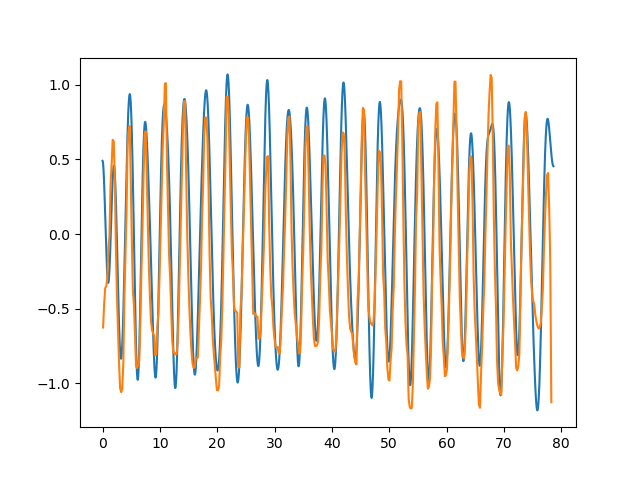

In [68]:
import scipy as sp
respnav_im = np.load('output_recons/vol0902_20240611/respnav_meas_MID00175_FID15580_pulseq2D_fire_spiralga_400mV_24MHz_editer.npy')
# respnav_im = sp.signal.detrend(respnav_im)

narms = 34
navdt = narms*samp_time_pt
time_rnav = np.arange(respnav_im.shape[0])*navdt + navdt/2
model = np.polyfit(time_rnav, respnav_im, 11)
predicted = np.polyval(model, time_rnav)
respnav_im -= predicted
# respnav_im -= np.mean(respnav_im)
plt.figure()
plt.plot(time_pt, pt_respiratory)
plt.plot(time_rnav, (respnav_im/np.percentile(respnav_im, 95))-0.2)
plt.show()



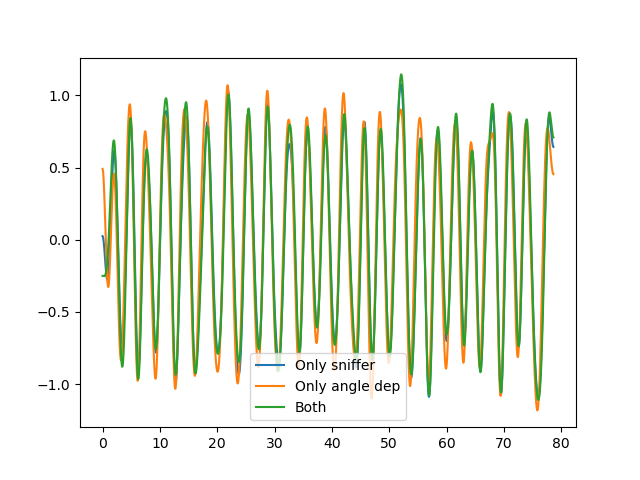

In [27]:
plt.figure()
plt.plot(time_pt, resp_method1, label='Only sniffer')
plt.plot(time_pt, resp_method2, label='Only angle dep')
plt.plot(time_pt, resp_method3, label='Both')
plt.legend()
plt.show()

## QA and ECG PT Jitter

/server/home/btasdelen/miniforge3/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Rejection ratio for pt peaks is 0.00 percent.

Rejection ratio for derivative pt peaks is 0.00 percent.

Peak difference 268.6 ± 11.0
Derivative peak difference 433.6 ± 22.2
Number of ECG triggers: 80.
Number of PT triggers: 79.
Number of missed PT triggers: 0.
Number of extraneous PT triggers: 0.
Number of derivative PT triggers: 79.
Number of missed derivative PT triggers: 1.
Number of extraneous derivative PT triggers: 1.


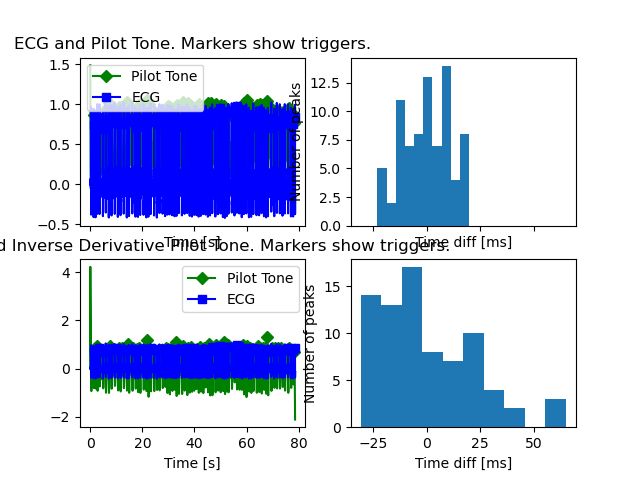

In [69]:
from scipy.signal import find_peaks
from pilottone.pt import beat_rejection, interval_peak_matching

%matplotlib widget

skip_time = 0.6 # [s]

# ECG Triggers
# ecg_peak_locs,_ = find_peaks(ecg_waveform[time_ecg > skip_time], prominence=0.7)
ecg_peak_locs = np.nonzero(ecg_trigs[time_ecg > skip_time])[0]
ecg_peak_locs += np.sum(time_ecg <= skip_time)

# PT Triggers
dt_pt = (time_pt[1] - time_pt[0])
Dmin = int(np.ceil(0.65/(dt_pt))) # Min distance between two peaks, should not be less than 0.6 secs (100 bpm max assumed)
pt_cardiac_peak_locs,_ = find_peaks(pt_cardiac[time_pt > skip_time], prominence=0.4, distance=Dmin)
pt_cardiac_peak_locs += np.sum(time_pt <= skip_time)

# PT Derivative Triggers
pt_cardiac_derivative_peak_locs,_ = find_peaks(pt_cardiac_derivative[time_pt > skip_time], prominence=0.6, distance=Dmin)
pt_cardiac_derivative_peak_locs += np.sum(time_pt <= skip_time)

# "Arryhtmia detection" by heart rate variation
hr_accept_list = beat_rejection(pt_cardiac_peak_locs*dt_pt, "post")
hr_accept_list_derivative = beat_rejection(pt_cardiac_derivative_peak_locs*dt_pt, "pre")
# TODO: Is pre post even correct? Why does it change? Need to investigate.
print(f'Rejection ratio for pt peaks is {100*(len(hr_accept_list) - np.sum(hr_accept_list))/len(hr_accept_list):.2f} percent.\n')
print(f'Rejection ratio for derivative pt peaks is {100*(len(hr_accept_list_derivative) - np.sum(hr_accept_list_derivative))/len(hr_accept_list_derivative):.2f} percent.\n')


# peak_diff, pt_peaks_selected = prepeak_matching(time_pt, pt_cardiac_peak_locs, time_ecg, ecg_peak_locs)
# derivative_peak_diff, pt_derivative_peaks_selected = prepeak_matching(time_pt, pt_cardiac_derivative_peak_locs, time_ecg, ecg_peak_locs)

peak_diff, miss_pks, extra_pks = interval_peak_matching(time_pt, pt_cardiac_peak_locs, time_ecg, ecg_peak_locs)
pt_peaks_selected = pt_cardiac_peak_locs

derivative_peak_diff, derivative_miss_pks, derivative_extra_pks = interval_peak_matching(time_pt, pt_cardiac_derivative_peak_locs, time_ecg, ecg_peak_locs)
pt_derivative_peaks_selected = pt_cardiac_derivative_peak_locs

# Create trigger waveforms from peak locations.
pt_cardiac_trigs = np.zeros((n_acq,), dtype=np.uint32)
pt_derivative_trigs = np.zeros((n_acq,), dtype=np.uint32)
pt_cardiac_trigs[pt_peaks_selected] = 1
pt_derivative_trigs[pt_derivative_peaks_selected] = 1

# Print some useful info

print(f'Peak difference {np.mean(peak_diff*1e3):.1f} \u00B1 {np.std(peak_diff*1e3):.1f}')
print(f'Derivative peak difference {np.mean(derivative_peak_diff*1e3):.1f} \u00B1 {np.std(derivative_peak_diff*1e3):.1f}')

print(f'Number of ECG triggers: {ecg_peak_locs.shape[0]}.')
print(f'Number of PT triggers: {pt_cardiac_peak_locs.shape[0]}.')
print(f'Number of missed PT triggers: {miss_pks.shape[0]}.')
print(f'Number of extraneous PT triggers: {extra_pks.shape[0]}.')
print(f'Number of derivative PT triggers: {pt_cardiac_derivative_peak_locs.shape[0]}.')
print(f'Number of missed derivative PT triggers: {derivative_miss_pks.shape[0]}.')
print(f'Number of extraneous derivative PT triggers: {derivative_extra_pks.shape[0]}.')


# Plots
f, axs = plt.subplots(2,2, sharex='col')
axs[0,0].plot(time_pt, pt_cardiac, '-gD', markevery=pt_cardiac_peak_locs, label='Pilot Tone')
axs[0,0].plot(time_ecg, ecg_waveform, '-bs', markevery=ecg_peak_locs, label='ECG')
axs[0,0].set_xlabel('Time [s]')
axs[0,0].legend()
axs[0,0].set_title('ECG and Pilot Tone. Markers show triggers.')

axs[0,1].hist((peak_diff - np.mean(peak_diff))*1e3)
axs[0,1].set_xlabel('Time diff [ms]')
axs[0,1].set_ylabel('Number of peaks')

axs[1,0].plot(time_pt, pt_cardiac_derivative, '-gD', markevery=pt_cardiac_derivative_peak_locs, label='Pilot Tone')
axs[1,0].plot(time_ecg, ecg_waveform, '-bs', markevery=ecg_peak_locs, label='ECG')
axs[1,0].set_xlabel('Time [s]')
axs[1,0].legend()
axs[1,0].set_title('ECG and Inverse Derivative Pilot Tone. Markers show triggers.')

axs[1,1].hist((derivative_peak_diff - np.mean(derivative_peak_diff))*1e3)
axs[1,1].set_xlabel('Time diff [ms]')
axs[1,1].set_ylabel('Number of peaks')

plt.show()


## Save the waveforms into the original data

In [ ]:
# Concat, and normalize pt waveforms.
import ctypes
pt_wf_data = np.vstack((pt_respiratory, pt_cardiac, pt_cardiac_trigs, pt_cardiac_derivative, pt_derivative_trigs))
pt_wf_data = ((pt_wf_data/np.max(np.abs(pt_wf_data))*(2**31-1)) + 2**31).astype(np.uint32)

pt_wf = ismrmrd.waveform.Waveform.from_array(pt_wf_data)
pt_wf._head.sample_time_us = ctypes.c_float(dt_pt*1e6)
pt_wf._head.waveform_id = ctypes.c_uint16(1025)
pt_wf._head.time_stamp = acq_list[0].acquisition_time_stamp

with ismrmrd.Dataset(ismrmrd_data_fullpath) as dset:
    dset.append_waveform(pt_wf)

print('Done writing the waveform.')


## TODO: Save the PT subtracted k-space